In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import cv2
from skimage.feature import local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt


## Functions

In [2]:
def extract_lbp_features(image, num_points, radius):
    lbp_features = []
    for channel in range(image.shape[2]):  # Iteriere über die Farbkanäle (RGB)
        lbp = local_binary_pattern(image[:, :, channel], num_points, radius, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        lbp_features.extend(hist)
    return lbp_features

def extract_hog_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_features = hog(gray_image, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False)
    return hog_features

def predict_image_HOG(image, classifier):
    # Verkleinere das Bild
    resized_image = cv2.resize(image, (300, 300))
    # Extrahiere die HOG-Merkmale
    hog_features = extract_hog_features(resized_image)
    # Führe die Vorhersage mit dem Klassifikator durch
    prediction = classifier.predict([hog_features])[0]
    # Bestimme die Vertrauenswahrscheinlichkeit für die Vorhersage
    confidence = max(classifier.predict_proba([hog_features])[0])
    return prediction, confidence

def predict_image_LBP(image, classifier, num_points, radius):
    # Verkleinere das Bild
    resized_image = cv2.resize(image, (300, 300))
    # Extrahiere die LBP-Merkmale
    lbp_features = extract_lbp_features(resized_image, num_points, radius)
    # Führe die Vorhersage mit dem Klassifikator durch
    prediction = classifier.predict([lbp_features])[0]
    # Bestimme die Vertrauenswahrscheinlichkeit für die Vorhersage
    confidence = max(classifier.predict_proba([lbp_features])[0])
    return prediction, confidence
    
def detect_face(image_path):
    # Laden des Gesichtserkennungs-Klassifikators (Haar-Cascade)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Laden des Bildes
    image = cv2.imread(image_path)
    
    if image is not None:
        # Konvertieren des Bildes in Graustufen
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Gesichter im Bild erkennen
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(300, 300))
        
        if len(faces) > 0:
            # Nehme das erste erkannte Gesicht
            (x, y, w, h) = faces[0]
            # Schneide das Gesicht aus
            face = image[y:y+h, x:x+w]
             # Zeichne ein Rechteck um das erkannte Gesicht
            cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
            
            return face
        else:
            print(f"No face detected in {image_path}")
            return None
    else:
        print(f"Failed to load image: {image_path}")
        return None

## Face detection

In [3]:
# Pfad zum Ordner mit den Unterordnern für jedes Individuum
base_path = "Bilder"

# Zielordner für die geschnittenen Gesichter
output_folder = 'Bilder_detected_faces'

# Erstellen des Zielordners, falls er noch nicht existiert
output_path = output_folder
os.makedirs(output_path, exist_ok=True)

# Durchlaufen der Ordner im Basispfad
for person_folder in os.listdir(base_path):
    person_folder_path = os.path.join(base_path, person_folder)
    # Überprüfen, ob es sich um einen Ordner handelt
    if os.path.isdir(person_folder_path):
        # Durchlaufen der Bilder im Unterordner
        for filename in os.listdir(person_folder_path):
            image_path = os.path.join(person_folder_path, filename)
            # Gesichtserkennung durchführen
            face = detect_face(image_path)
            if face is not None:
                # Pfad für das ausgeschnittene Gesicht
                new_folder_path = os.path.join(output_path, person_folder)
                os.makedirs(new_folder_path, exist_ok=True)
                new_image_path = os.path.join(new_folder_path, f"{filename.split('.')[0]}_face.jpg")
                # Speichern des ausgeschnittenen Gesichts als neues Bild
                cv2.imwrite(new_image_path, face)
                print(f"Gesicht in {filename} wurde erfolgreich ausgeschnitten und als {new_image_path} gespeichert.")
            else:
                print(f"Fehler beim Ausschneiden des Gesichts in {filename}.")

print("Gesichtserkennung und Ausschneiden abgeschlossen.")

Gesicht in WIN_20240402_16_36_01_Pro (2).jpg wurde erfolgreich ausgeschnitten und als Bilder_detected_faces\Nino\WIN_20240402_16_36_01_Pro (2)_face.jpg gespeichert.
Gesicht in WIN_20240402_16_36_01_Pro (3).jpg wurde erfolgreich ausgeschnitten und als Bilder_detected_faces\Nino\WIN_20240402_16_36_01_Pro (3)_face.jpg gespeichert.
Gesicht in WIN_20240402_16_36_01_Pro (4).jpg wurde erfolgreich ausgeschnitten und als Bilder_detected_faces\Nino\WIN_20240402_16_36_01_Pro (4)_face.jpg gespeichert.
Gesicht in WIN_20240402_16_36_01_Pro (5).jpg wurde erfolgreich ausgeschnitten und als Bilder_detected_faces\Nino\WIN_20240402_16_36_01_Pro (5)_face.jpg gespeichert.
Gesicht in WIN_20240402_16_36_01_Pro (6).jpg wurde erfolgreich ausgeschnitten und als Bilder_detected_faces\Nino\WIN_20240402_16_36_01_Pro (6)_face.jpg gespeichert.
Gesicht in WIN_20240402_16_36_01_Pro.jpg wurde erfolgreich ausgeschnitten und als Bilder_detected_faces\Nino\WIN_20240402_16_36_01_Pro_face.jpg gespeichert.
Gesicht in WIN_202

## Erstelle Augmented Bilder

In [4]:
# Define the path to the dataset folder
data_folder = "Bilder_detected_faces"

# Define the new subfolder name for augmented images
new_subfolder = "Augmented"

# Iterate over the folders in the dataset folder
for folder_name in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, folder_name)
    # Check if the item is a folder
    if os.path.isdir(folder_path):
        # Create a new subfolder for augmented images
        new_folder_path = os.path.join(folder_path, new_subfolder)
        os.makedirs(new_folder_path, exist_ok=True)
        # Iterate over the files in the folder
        for file_name in os.listdir(folder_path):
            # Assuming the files are image files, you can adjust the file type according to your dataset
            # Read the image using OpenCV
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(folder_path, file_name)
                image = cv2.imread(image_path)
                # Check if the image is loaded successfully
                if image is not None:
                     # Convert the image from BGR to RGB
                    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    # Perform image augmentation
                    # Resize the image to a desired size
                    resized_image = cv2.resize(rgb_image, (300, 300))
                    datagen = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        fill_mode='constant'
                    )
                    # Reshape the image to add batch dimension
                    reshaped_image = resized_image.reshape((1,) + resized_image.shape)
                    # Generate and save augmented images
                    i = 0
                    for batch in datagen.flow(reshaped_image, batch_size=1, save_to_dir=new_folder_path, save_prefix='aug', save_format='jpg'):
                        i += 1
                        if i >= 10:
                            break  # Break the loop after generating 100 augmented images
                else:
                    print(f"Failed to load image: {image_path}")
            else:
                print(f"Skipping non-image file: {file_name}")
           

            

Skipping non-image file: Augmented
Skipping non-image file: Augmented


## Hog Feature Extraction

In [5]:
from skimage.feature import hog
import cv2

# Initialize empty lists to store HOG features and labels
hog_features = []
hog_labels = []

# Iterate over the folders in the dataset folder
for folder_name in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, folder_name)
    # Check if the item is a folder
    if os.path.isdir(folder_path):
        # Get the path to the augmented folder
        augmented_folder_path = os.path.join(folder_path, new_subfolder)
        # Check if the augmented folder exists
        if os.path.exists(augmented_folder_path):
            # Iterate over the files in the augmented folder
            for file_name in os.listdir(augmented_folder_path):
                # Read the image using OpenCV
                image_path = os.path.join(augmented_folder_path, file_name)
                image = cv2.imread(image_path)
                # Check if the image is loaded successfully
                if image is not None:
                    # Convert the image to grayscale
                    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    # Perform HOG feature extraction
                    hog_feature = hog(gray_image, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False)
                    # Add the HOG feature to the list of features
                    hog_features.append(hog_feature)
                    # Add the label to the list of labels
                    hog_labels.append(folder_name)
                    # Print image filename, HOG features, and label
                    print(f"Image: {file_name}, HOG features: {hog_feature}, Label: {folder_name}")
                else:
                    print(f"Failed to load image: {image_path}")

print(f"Total HOG features: {len(hog_features)}")
print(f"Total labels: {len(hog_labels)}")


Image: aug_0_1043.jpg, HOG features: [0.01181369 0.         0.         ... 0.05963606 0.0588162  0.09734943], Label: Nino
Image: aug_0_1045.jpg, HOG features: [0.4287528 0.2784729 0.1214532 ... 0.        0.        0.       ], Label: Nino
Image: aug_0_1119.jpg, HOG features: [0.2613939  0.23088459 0.1703026  ... 0.         0.         0.        ], Label: Nino
Image: aug_0_1133.jpg, HOG features: [0.04137973 0.00940634 0.00819941 ... 0.         0.         0.        ], Label: Nino
Image: aug_0_1139.jpg, HOG features: [0.         0.         0.00261609 ... 0.         0.         0.        ], Label: Nino
Image: aug_0_115.jpg, HOG features: [0.06863544 0.02573708 0.06542758 ... 0.         0.         0.        ], Label: Nino
Image: aug_0_1157.jpg, HOG features: [0.25423373 0.22683097 0.26534336 ... 0.         0.         0.        ], Label: Nino
Image: aug_0_1168.jpg, HOG features: [0. 0. 0. ... 0. 0. 0.], Label: Nino
Image: aug_0_1175.jpg, HOG features: [0.33434518 0.13753731 0.08305773 ... 0.00

## LBP Feature Extraction

In [6]:
# Initialize empty list to store LBP features
lbp_features = []
lbp_labels = []
 
# Parameter für LBP festlegen
num_points = 24
radius = 2

for folder_name in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, folder_name)
    # Check if the item is a folder
    if os.path.isdir(folder_path):
        # Get the path to the augmented folder
        augmented_folder_path = os.path.join(folder_path, new_subfolder)
        # Check if the augmented folder exists
        if os.path.exists(augmented_folder_path):
            # Iterate over the files in the augmented folder
            for file_name in os.listdir(augmented_folder_path):
                # Read the image using OpenCV
                image_path = os.path.join(augmented_folder_path, file_name)
                image = cv2.imread(image_path)
                # Check if the image is loaded successfully
                if image is not None:
                    lbp_feature = extract_lbp_features(image, num_points, radius)
                    lbp_features.append(lbp_feature)
                    # Add the label to the list of labels
                    lbp_labels.append(folder_name)
                    print(f"Image: {file_name}, LBP features: {lbp_feature}, Label: {folder_name}")
                else:
                    print(f"Failed to load image: {image_path}")


Image: aug_0_1043.jpg, LBP features: [0.015566666666649371, 0.014977777777761136, 0.004733333333328074, 0.014722222222205865, 0.007666666666658148, 0.011722222222209198, 0.009366666666656259, 0.018222222222201975, 0.017866666666646814, 0.03169999999996478, 0.04071111111106587, 0.0765333333332483, 0.1017444444443314, 0.10844444444432395, 0.04837777777772402, 0.03947777777773391, 0.023599999999973777, 0.029922222222188974, 0.01729999999998078, 0.02034444444442184, 0.01277777777776358, 0.014922222222205642, 0.01124444444443195, 0.008066666666657703, 0.1484333333331684, 0.15155555555538716, 0.014244444444428617, 0.012844444444430173, 0.003322222222218531, 0.011644444444431506, 0.007477777777769469, 0.01178888888887579, 0.00863333333332374, 0.01951111111108943, 0.018211111111090875, 0.03167777777774258, 0.04223333333328641, 0.0792666666665786, 0.1088222222221013, 0.11188888888876457, 0.04938888888883401, 0.04023333333328863, 0.02214444444441984, 0.03112222222218764, 0.01636666666664848, 0.0

## Random Forest

In [7]:
from sklearn.model_selection import cross_val_score

## lbp Random Forest
# Aufteilung der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(lbp_features, lbp_labels, test_size=0.2, random_state=42)
 
# Initialisierung des Random-Forest-Klassifikators
rf_classifier_lbp = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1, verbose=0 , max_depth=5, criterion='gini')
 
# Durchführung der Kreuzvalidierung mit 5 Faltungen
cv_scores = cross_val_score(rf_classifier_lbp, X_train, y_train, cv=5)

# Trainieren des Random-Forest-Modells auf dem gesamten Trainingsdatensatz
rf_classifier_lbp.fit(X_train, y_train)
 
# Evaluierung des Modells auf dem Testdatensatz (optional)
accuracy = rf_classifier_lbp.score(X_test, y_test)
predicted = rf_classifier_lbp.predict(X_test)

# Ausgabe der Ergebnisse
print("Cross-Validation Scores lbp:", cv_scores)
print("Mean Accuracy (Cross-Validation) lbp:", cv_scores.mean())
print("Accuracy (Test Set) lbp:", accuracy)
print("Predicted (Test Set) lbp:", predicted)


## HOG Randon Forest
X_train, X_test, y_train, y_test = train_test_split(hog_features, hog_labels, test_size=0.2, random_state=42)

# Initialisierung des Random-Forest-Klassifikators
rf_classifier_hog = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1, verbose=0, max_depth=5, max_features='sqrt', criterion='gini')

# Durchführung der Kreuzvalidierung mit 5 Faltungen
cv_scores = cross_val_score(rf_classifier_hog, X_train, y_train, cv=5)

# Trainieren des Random-Forest-Modells auf dem gesamten Trainingsdatensatz
rf_classifier_hog.fit(X_train, y_train)

# Evaluierung des Modells auf dem Testdatensatz (optional)
accuracy = rf_classifier_hog.score(X_test, y_test)
predicted = rf_classifier_hog.predict(X_test)

# Ausgabe der Ergebnisse
print("Cross-Validation Scores hog:", cv_scores)
print("Mean Accuracy (Cross-Validation) hog:", cv_scores.mean())
print("Accuracy (Test Set) hog:", accuracy)
print("Predicted (Test Set) hog:", predicted)
 

Cross-Validation Scores lbp: [0.90909091 0.88549618 0.92366412 0.88549618 0.91603053]
Mean Accuracy (Cross-Validation) lbp: 0.9039555863983345
Accuracy (Test Set) lbp: 0.9090909090909091
Predicted (Test Set) lbp: ['Robin' 'Robin' 'Nino' 'Robin' 'Nino' 'Nino' 'Robin' 'Nino' 'Robin'
 'Robin' 'Robin' 'Robin' 'Robin' 'Nino' 'Robin' 'Robin' 'Nino' 'Nino'
 'Robin' 'Nino' 'Robin' 'Nino' 'Nino' 'Nino' 'Robin' 'Robin' 'Robin'
 'Nino' 'Nino' 'Robin' 'Nino' 'Nino' 'Robin' 'Nino' 'Nino' 'Robin' 'Nino'
 'Nino' 'Robin' 'Nino' 'Nino' 'Nino' 'Nino' 'Robin' 'Nino' 'Nino' 'Nino'
 'Robin' 'Nino' 'Robin' 'Robin' 'Robin' 'Nino' 'Robin' 'Robin' 'Robin'
 'Robin' 'Nino' 'Nino' 'Nino' 'Nino' 'Robin' 'Nino' 'Robin' 'Robin' 'Nino'
 'Robin' 'Nino' 'Robin' 'Nino' 'Nino' 'Nino' 'Nino' 'Nino' 'Nino' 'Robin'
 'Nino' 'Nino' 'Robin' 'Nino' 'Robin' 'Robin' 'Nino' 'Robin' 'Nino' 'Nino'
 'Nino' 'Robin' 'Robin' 'Robin' 'Nino' 'Robin' 'Robin' 'Robin' 'Nino'
 'Robin' 'Robin' 'Robin' 'Nino' 'Robin' 'Robin' 'Nino' 'Nino' 'Nino

## Bilder predicten

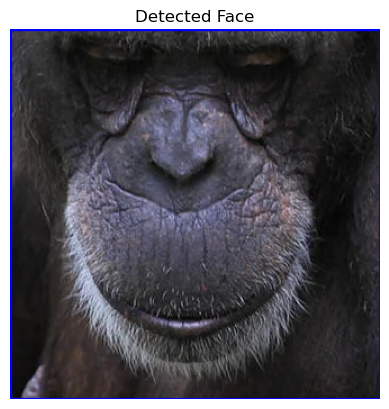

Prediction LBP for 2010-06-14-Affen-Zoo-Hannover-7047-c-PETA-D.png: Robin, Confidence: 0.9253641215077746
Prediction HOG for 2010-06-14-Affen-Zoo-Hannover-7047-c-PETA-D.png: Robin, Confidence: 0.7931433831887461


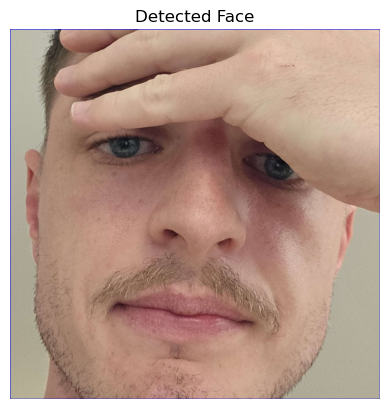

Prediction LBP for 20240326_154707.jpg: Robin, Confidence: 0.7473666332283102
Prediction HOG for 20240326_154707.jpg: Robin, Confidence: 0.8290799511054283


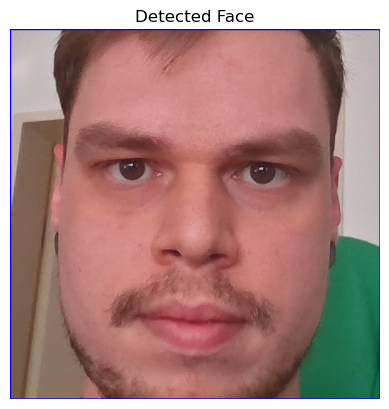

Prediction LBP for image (2).jpg: Robin, Confidence: 0.87280679356749
Prediction HOG for image (2).jpg: Robin, Confidence: 0.8034160377216325


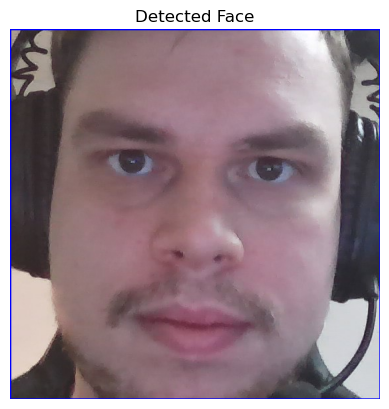

Prediction LBP for image (3).jpg: Robin, Confidence: 0.882750956296945
Prediction HOG for image (3).jpg: Robin, Confidence: 0.7516703835437255


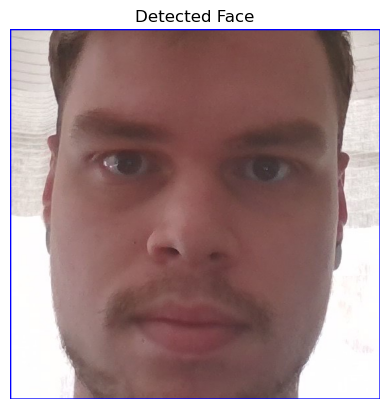

Prediction LBP for image (4).jpg: Robin, Confidence: 0.8868589689392226
Prediction HOG for image (4).jpg: Robin, Confidence: 0.8087667851134116


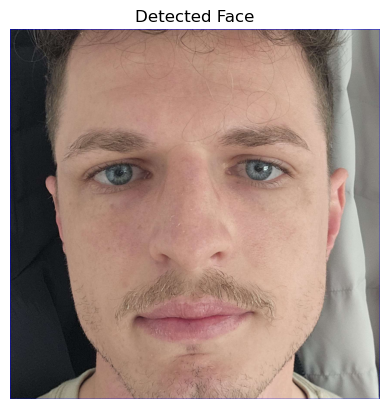

Prediction LBP for robin191.jpg: Robin, Confidence: 0.7376209117910524
Prediction HOG for robin191.jpg: Robin, Confidence: 0.8480875958539906


In [8]:
# Ordnerpfad mit den zu klassifizierenden Bildern
predict_folder = "predict"

# Iteriere über die Bilder im Ordner und führe die Vorhersage durch
for filename in os.listdir(predict_folder):
    image_path = os.path.join(predict_folder, filename)
    # Gesichtserkennung durchführen
    face = detect_face(image_path)
    if face is not None:
        # Plotte das Originalbild mit dem markierten Gesicht
        plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Detected Face')
        plt.show()
        # Vorhersage mit LBP durchführen
        prediction, confidence = predict_image_LBP(face, rf_classifier_lbp, num_points, radius)
        if prediction is not None:
            print(f"Prediction LBP for {filename}: {prediction}, Confidence: {confidence}")
        # Vorhersage mit HOG durchführen
        prediction, confidence = predict_image_HOG(face, rf_classifier_hog)
        if prediction is not None:
            print(f"Prediction HOG for {filename}: {prediction}, Confidence: {confidence}")
    else:
        print(f"Failed to detect face in {filename}")
        
        
        